In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.stats import norm
import re

In [93]:
## Read the DM file

dm = np.loadtxt('dm')
positions_dm = dm[:,2:5]
vectors_dm = dm[:,5:8]
magnitudes = np.linalg.norm(vectors_dm, axis=1)
distances = np.linalg.norm(positions_dm, axis=1)

## Read the jfile

jfile = np.loadtxt('jfile')
jvalues = jfile[:,5:6]
positions_jfile = jfile[:,2:5]

## Read the inpsd.dat file

with open('inpsd.dat', 'r') as f:
    file_content = f.read()
cell_line = re.search(r'cell\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)', file_content)
a11, a12, a13, a21, a22, a23, a31, a32, a33 = [float(cell_line.group(i)) for i in range(1, 10)]
cell = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])

## Read the momfile

momf = np.loadtxt('momfile')
moment_value = momf[2]

## Read kfile

kf = np.loadtxt('kfile')
anisotropy_k1 = kf[2]
anisotropy_type = int(kf[1])
anisotropy_k2 = kf[3]
vector_anisotropy = kf[4:7]
anisotropy_ratio = kf[7]

In [94]:
## Definitions
side_spins = 50 ## the size of the spin lattice
mean_phi = 0 ## the mean (in degrees) for phi angles in the DMI
mean_theta = 90 ## the mean (in degrees) for theta angles in the DMI
scale_var_phi = 10.0 ## in degrees, which serves for the phi angle
scale_var_theta = 10.0 ## in degrees, which serves for the theta angle
perpendicular_condition = False # condition to apply Dij . rij = 0
percentile_epsilon = 25.0 ## percentile of a given epsilon (scaling factor) from a real calculation
epsilon = 16.0 ## the epsilon (scaling factor) compatible with the percentile above
initial_vector_mag = [0,0,1] ## set all vectors initially at that vector in the momfile
mean_magnitudes = 12.0 ## set the mean of the magnitudes in our model
plot_3d = True ## if you want to do the 3D plots (could be quite memory consuming)
around_initial_vectors = True ## condition to set the distribution around the initial DMI vectors
highest_comes_first = True ## model in which the highest magnitude scaling factors to nearest-neighbors

## Calculations
total_spins = (side_spins**2)

In [95]:
## Generate theta and phi parameters following a normal distribution
if not around_initial_vectors:
    theta_degrees = np.random.normal(loc=mean_theta, scale=scale_var_theta, size=(len(magnitudes)*total_spins,))
    phi_degrees = np.random.normal(loc=mean_phi, scale=scale_var_phi, size=(len(magnitudes)*total_spins,))
else:
    theta_conditional = np.zeros((len(magnitudes), total_spins))
    phi_conditional = np.zeros((len(magnitudes), total_spins))
    theta_cond_initial = np.zeros((len(magnitudes), total_spins))
    phi_cond_initial = np.zeros((len(magnitudes), total_spins))
    for i in range(len(magnitudes)):
        unit_dm_vector_now = vectors_dm[i]/magnitudes[i]
        mean_phi_conditional = np.degrees(np.arctan2(unit_dm_vector_now[1], unit_dm_vector_now[0]))
        mean_theta_conditional = np.degrees(np.arccos(unit_dm_vector_now[2]))
        theta_conditional[i] = np.random.normal(loc=mean_theta_conditional, scale=scale_var_theta, size=(total_spins,))
        phi_conditional[i] = np.random.normal(loc=mean_phi_conditional, scale=scale_var_phi, size=(total_spins,))
        theta_cond_initial[i] = np.random.normal(loc=mean_theta_conditional, scale=0.001, size=(total_spins,))
        phi_cond_initial[i] = np.random.normal(loc=mean_phi_conditional, scale=0.001, size=(total_spins,))

## Convert theta and phi to radians
if not around_initial_vectors:
    theta = np.deg2rad(theta_degrees)
    phi = np.deg2rad(phi_degrees)
else:
    theta_cond = np.deg2rad(theta_conditional)
    phi_cond = np.deg2rad(phi_conditional)
    thetac_initial = np.deg2rad(theta_cond_initial)
    phic_initial = np.deg2rad(phi_cond_initial) 

## Define spherical coordinates with r=1
if not around_initial_vectors:
    r = np.ones_like(theta)
else:
    r = np.ones_like(theta_cond)

## Convert spherical coordinates to cartesian coordinates
if not around_initial_vectors:
    x_components = r*np.sin(theta)*np.cos(phi)
    y_components = r*np.sin(theta)*np.sin(phi)
    z_components = r*np.cos(theta)
else:
    x_components_cond = r*np.sin(theta_cond)*np.cos(phi_cond)
    y_components_cond = r*np.sin(theta_cond)*np.sin(phi_cond)
    z_components_cond = r*np.cos(theta_cond)
    x_components_cond_ini = r*np.sin(thetac_initial)*np.cos(phic_initial)
    y_components_cond_ini = r*np.sin(thetac_initial)*np.sin(phic_initial)
    z_components_cond_ini = r*np.cos(thetac_initial)    
    
## Combine x, y, and z components into 3-dimensional vectors
if not around_initial_vectors:
    new_dm_vectors = np.column_stack((x_components, y_components, z_components))
else:
    new_dm_vectors_cond = np.zeros((len(magnitudes), total_spins, 3))
    for i in range(len(magnitudes)):
        new_dm_vectors_cond[i] = np.column_stack((x_components_cond[i], y_components_cond[i], z_components_cond[i]))

## Confirm that all vectors have magnitude 1
if not around_initial_vectors:
    assert np.allclose(np.linalg.norm(new_dm_vectors, axis=1), 1.0)
else:
    assert np.allclose(np.linalg.norm(new_dm_vectors_cond, axis=2), 1.0)

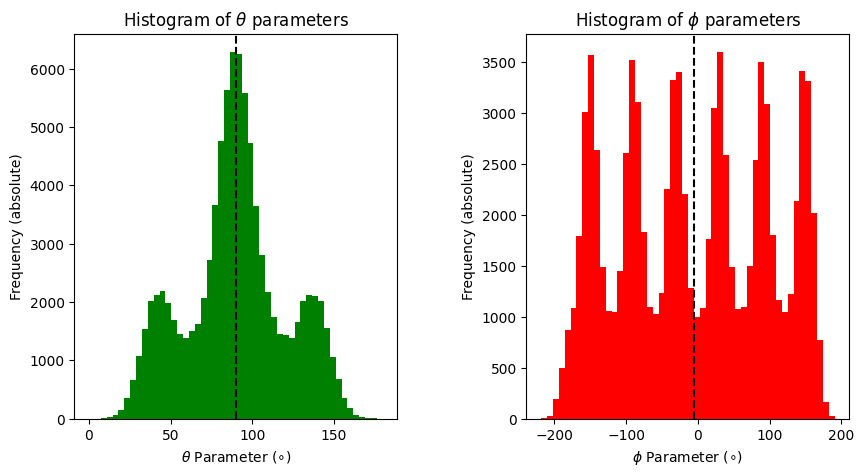

In [96]:
## Plot histogram of theta and phi
## Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

## Plot histogram of theta parameters
if not around_initial_vectors:
    ax1.hist(theta_degrees, bins=side_spins, color='green')
else:
    ax1.hist(theta_conditional.flatten(), bins=side_spins, color='green')
ax1.set_xlabel(r'$\theta$ Parameter ($\circ$)')
ax1.set_ylabel('Frequency (absolute)')
ax1.set_title(r'Histogram of $\theta$ parameters')
if not around_initial_vectors:
    ax1.axvline(mean_theta, color='black', ls='--')
else:
    ax1.axvline(np.mean(theta_conditional.flatten()), color='black', ls='--')

## Plot histogram of phi parameters
if not around_initial_vectors:
    ax2.hist(phi_degrees, bins=side_spins, color='red')
else:
    ax2.hist(phi_conditional.flatten(), bins=side_spins, color='red')
ax2.set_xlabel(r'$\phi$ Parameter ($\circ$)')
ax2.set_ylabel('Frequency (absolute)')
ax2.set_title(r'Histogram of $\phi$ parameters')
if not around_initial_vectors:
    ax2.axvline(mean_phi, color='black', ls='--')
else:
    ax2.axvline(np.mean(phi_conditional.flatten()), color='black', ls='--')

## Adjust spacing between subplots
fig.subplots_adjust(wspace=0.4)

## Display the plots
plt.show()

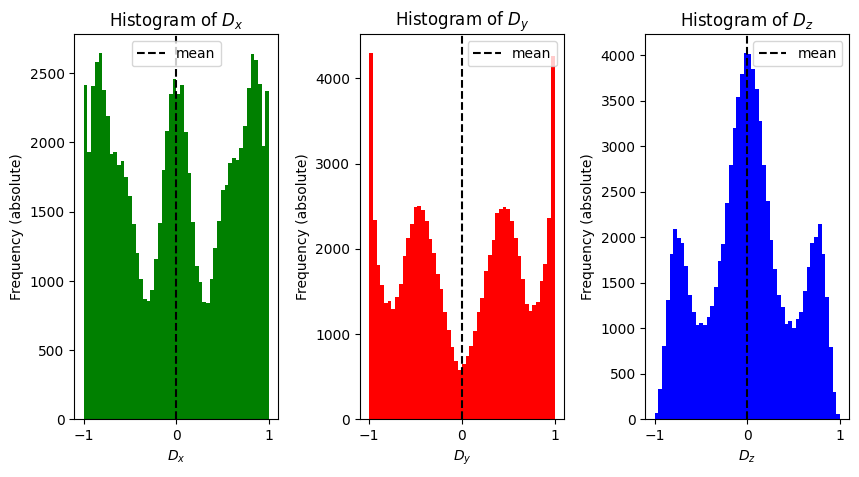

In [97]:
## Plot histogram of (x,y,z) components to check the distribution they follow

## Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

## Plot histogram of x_componentes parameters
if not around_initial_vectors:
    ax1.hist(x_components, bins=side_spins, color='green')
else:
    ax1.hist(x_components_cond.flatten(), bins=side_spins, color='green')
ax1.set_xlabel(r'$D_{x}$')
ax1.set_ylabel('Frequency (absolute)')
ax1.set_title(r'Histogram of $D_{x}$')
if not around_initial_vectors:
    ax1.axvline(np.mean(x_components), color='black', ls='--', label='mean')
else:
    ax1.axvline(np.mean(x_components_cond.flatten()), color='black', ls='--', label='mean')
ax1.legend(loc='best')

## Plot histogram of y_componentes parameters
if not around_initial_vectors:
    ax2.hist(y_components, bins=side_spins, color='red')
else:
    ax2.hist(y_components_cond.flatten(), bins=side_spins, color='red')
ax2.set_xlabel(r'$D_{y}$')
ax2.set_ylabel('Frequency (absolute)')
ax2.set_title(r'Histogram of $D_{y}$')
if not around_initial_vectors:
    ax2.axvline(np.mean(y_components), color='black', ls='--', label='mean')
else:
    ax2.axvline(np.mean(y_components_cond.flatten()), color='black', ls='--', label='mean')
ax2.legend(loc='best')

## Plot histogram of z_componentes parameters
if not around_initial_vectors:
    ax3.hist(z_components, bins=side_spins, color='blue')
else:
    ax3.hist(z_components_cond.flatten(), bins=side_spins, color='blue')
ax3.set_xlabel(r'$D_{z}$')
ax3.set_ylabel('Frequency (absolute)')
ax3.set_title(r'Histogram of $D_{z}$')
if not around_initial_vectors:
    ax3.axvline(np.mean(z_components), color='black', ls='--', label='mean')
else:
    ax3.axvline(np.mean(z_components_cond.flatten()), color='black', ls='--', label='mean')
ax3.legend(loc='best')

## Adjust spacing between subplots
fig.subplots_adjust(wspace=0.4)

## Display the plots
plt.show()

/var/folders/ls/f_gxhb7j2kdc0tkgrythk1jc0000gn/T/ipykernel_22073/2766231638.py:29: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


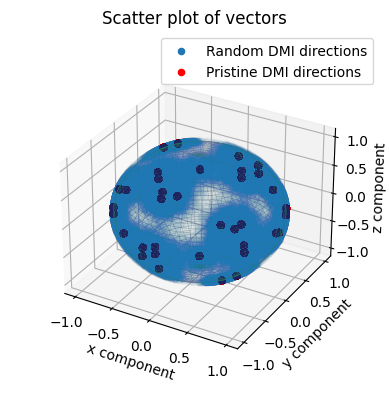

In [98]:
## Plot 3D scatter plot of vectors
mean_theta_rad = np.deg2rad(mean_theta)
mean_phi_rad = np.deg2rad(mean_phi)
x_component_initial_vector = np.sin(mean_theta_rad)*np.cos(mean_phi_rad)
y_component_initial_vector = np.sin(mean_theta_rad)*np.sin(mean_phi_rad)
z_component_initial_vector = np.cos(mean_theta_rad)
initial_vector = np.array([[x_component_initial_vector, y_component_initial_vector, z_component_initial_vector]])
if plot_3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if not around_initial_vectors:
        ax.scatter(x_components, y_components, z_components, alpha=0.01, label='Initial directions')
        ax.quiver(0, 0, 0, x_component_initial_vector, y_component_initial_vector, z_component_initial_vector, color='black', linewidth=3, arrow_length_ratio=0.1)
    else:
        ax.scatter(x_components_cond.flatten(), y_components_cond.flatten(), z_components_cond.flatten(), alpha=0.01, label='Random DMI directions')
        ax.scatter(x_components_cond_ini.flatten(), y_components_cond_ini.flatten(), z_components_cond_ini.flatten(), alpha=0.5, color='red', label='Pristine DMI directions')
    # Plot the sphere with lines of latitude and longitude
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', linewidths=0.2)
    # End plot
    ax.set_xlabel('x component')
    ax.set_ylabel('y component')
    ax.set_zlabel('z component')
    ax.set_title('Scatter plot of vectors')
    ax.dist = 12
    legend = ax.legend(scatterpoints=1)
    if not around_initial_vectors:
        legend.legendHandles[0].set_alpha(1)
    else:
        legend.legendHandles[0].set_alpha(1)
        legend.legendHandles[1].set_alpha(1)
    plt.show()

In [99]:
if not around_initial_vectors:
    ## Shuffle the array
    shuffled_arr = np.random.permutation(new_dm_vectors)
    ## Reshape the shuffled array into groups
    grouped_dm_arr = np.reshape(shuffled_arr, (total_spins, len(magnitudes), -1))
else:
    grouped_dm_arr = np.transpose(new_dm_vectors_cond.copy(), (1,0,2))

In [100]:
## Function to project the vector onto the plane defined by rij as the normal vector
## Needed if perpendicular_condition = True

def project_vector_onto_plane(vector, normal):
    # Ensure that vector and normal are both unit vectors
    vector = vector/np.linalg.norm(vector)
    normal = normal/np.linalg.norm(normal)
    
    # Project vector onto the plane defined by normal
    v_proj = vector - np.dot(vector, normal)*normal
    
    # Ensure that the magnitude of the projected vector is 1
    v_proj = v_proj/np.linalg.norm(v_proj)
    
    return v_proj

In [101]:
## Calculate the z-score corresponding to the given percentiles
z_score = norm.ppf((100 - percentile_epsilon)/100)

## Calculate the standard deviation such that the integral between the percentiles matches (100 - 2*percentile_epsilon)
std_dev_mag = (epsilon - mean_magnitudes) / z_score

## Generate the array of random values with the desired mean and standard deviation
magnitudes_arr = np.random.normal(loc=mean_magnitudes, scale=std_dev_mag, size=len(magnitudes)*total_spins)

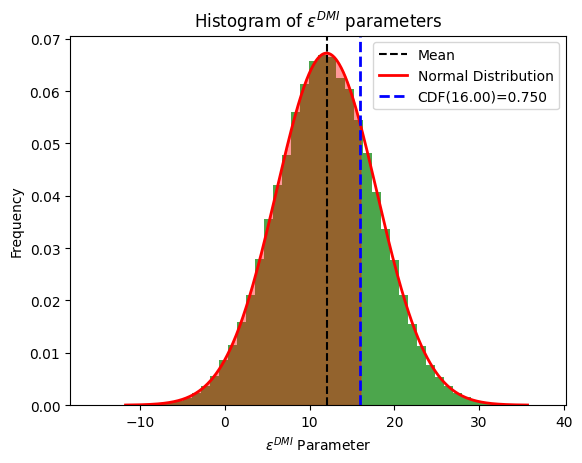

In [102]:
## Plot histogram of the epsilon values to check if they follow a normal distribution

x_values_mag = np.linspace(mean_magnitudes - 4*std_dev_mag, mean_magnitudes + 4*std_dev_mag, 1000)
y_values_mag = norm.pdf(x_values_mag, mean_magnitudes, std_dev_mag)
cdf_mag = norm.cdf(epsilon, loc=mean_magnitudes, scale=std_dev_mag)
x_area_mag = np.linspace(mean_magnitudes - 4*std_dev_mag, epsilon, 1000)
y_area_mag = norm.pdf(x_area_mag, mean_magnitudes, std_dev_mag)

plt.hist(magnitudes_arr, alpha=0.7, density=True, bins=side_spins, color='green')
plt.xlabel(r'$\epsilon^{DMI}$ Parameter')
plt.ylabel('Frequency')
plt.title(r'Histogram of $\epsilon^{DMI}$ parameters')
plt.axvline(mean_magnitudes, color='black', ls='--', label='Mean')
plt.plot(x_values_mag, y_values_mag, color='r', linewidth=2, label='Normal Distribution')
plt.fill_between(x_area_mag, y_area_mag, color='r', alpha=0.4)
plt.axvline(epsilon, color='b', linestyle='--', linewidth=2, label=f'CDF({epsilon:.2f})={cdf_mag:.3f}')
plt.legend(loc='best')
plt.show()

In [103]:
## Shuffle the magnitudes array in a random or ordered manner
if not highest_comes_first:
    shuffled_mag_arr = np.random.permutation(magnitudes_arr)
else:
    abs_mag_arr = np.abs(magnitudes_arr)
    sorted_indices_mag_arr = np.argsort(abs_mag_arr)[::-1]
    shuffled_mag_arr = np.sign(magnitudes_arr[sorted_indices_mag_arr])*abs_mag_arr[sorted_indices_mag_arr]

## Reshape the shuffled magnitudes array into groups
if not highest_comes_first:
    grouped_mag_arr = np.reshape(shuffled_mag_arr, (total_spins, len(magnitudes), -1))
else:
    shuffle_reshape = np.reshape(shuffled_mag_arr, (len(magnitudes), total_spins, -1))
    reshape_random_permutation = np.zeros_like(shuffle_reshape)
    for i in range(len(shuffle_reshape)):
        reshape_random_permutation[i] = np.random.permutation(shuffle_reshape[i])
    grouped_mag_arr = np.transpose(reshape_random_permutation, (1,0,2))

In [104]:
## Now that we have the DMI vectors and magnitudes, build the groups of interactions

groups_interactions = []
for i in range(total_spins):
    group_now = []
    for k in range(len(magnitudes)):
        if perpendicular_condition:
            proj_v = np.array(project_vector_onto_plane(grouped_dm_arr[i][k], positions_dm[k]))
            group_now.append([positions_dm[k], proj_v*grouped_mag_arr[i][k]*magnitudes[k], distances[k]])
        else:
            group_now.append([positions_dm[k], grouped_dm_arr[i][k]*grouped_mag_arr[i][k]*magnitudes[k], distances[k]])
    groups_interactions.append(group_now)

groups_int = np.asarray(groups_interactions)

/var/folders/ls/f_gxhb7j2kdc0tkgrythk1jc0000gn/T/ipykernel_22073/2603538638.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_int = np.asarray(groups_interactions)


In [105]:
## Generate positions of all sites
positions_lattice = np.zeros((side_spins, side_spins, 3))
for i in range(side_spins):
    for j in range(side_spins):
        positions_lattice[i,j,:] = i*cell[0,:] + j*cell[1,:]

## Compute distances between all sites with periodic boundary conditions
diffs = positions_lattice.reshape((-1,1,3)) - positions_lattice.reshape((1,-1,3))
diffs_basis = np.round(diffs.dot(np.linalg.inv(cell)))
diffs_basis = np.where(diffs_basis > side_spins/2, diffs_basis - side_spins, diffs_basis)
diffs_basis = np.where(diffs_basis < -side_spins/2, diffs_basis + side_spins, diffs_basis)
diffs = np.dot(diffs_basis, cell)
distances_lattice = np.linalg.norm(diffs, axis=-1)

## Set diagonal elements to infinity to avoid self-interaction
np.fill_diagonal(distances_lattice, np.inf)

## Find indices of the nearest neighbors for each site
neighbors_lattice = np.argsort(distances_lattice, axis=1)[:, :len(magnitudes)]

# Create an array of zeros to store the distance vectors
distance_vectors = np.zeros((len(neighbors_lattice), len(neighbors_lattice[0]), 3))

# Loop over all sites and their neighbors
for i in range(len(neighbors_lattice)):
    for j, idx in enumerate(neighbors_lattice[i]):
        # Pick the corresponding distance vector from `diffs`
        diff = diffs[i, idx]
        # Store the distance vector in the `distance_vectors` array
        distance_vectors[i, j] = diff

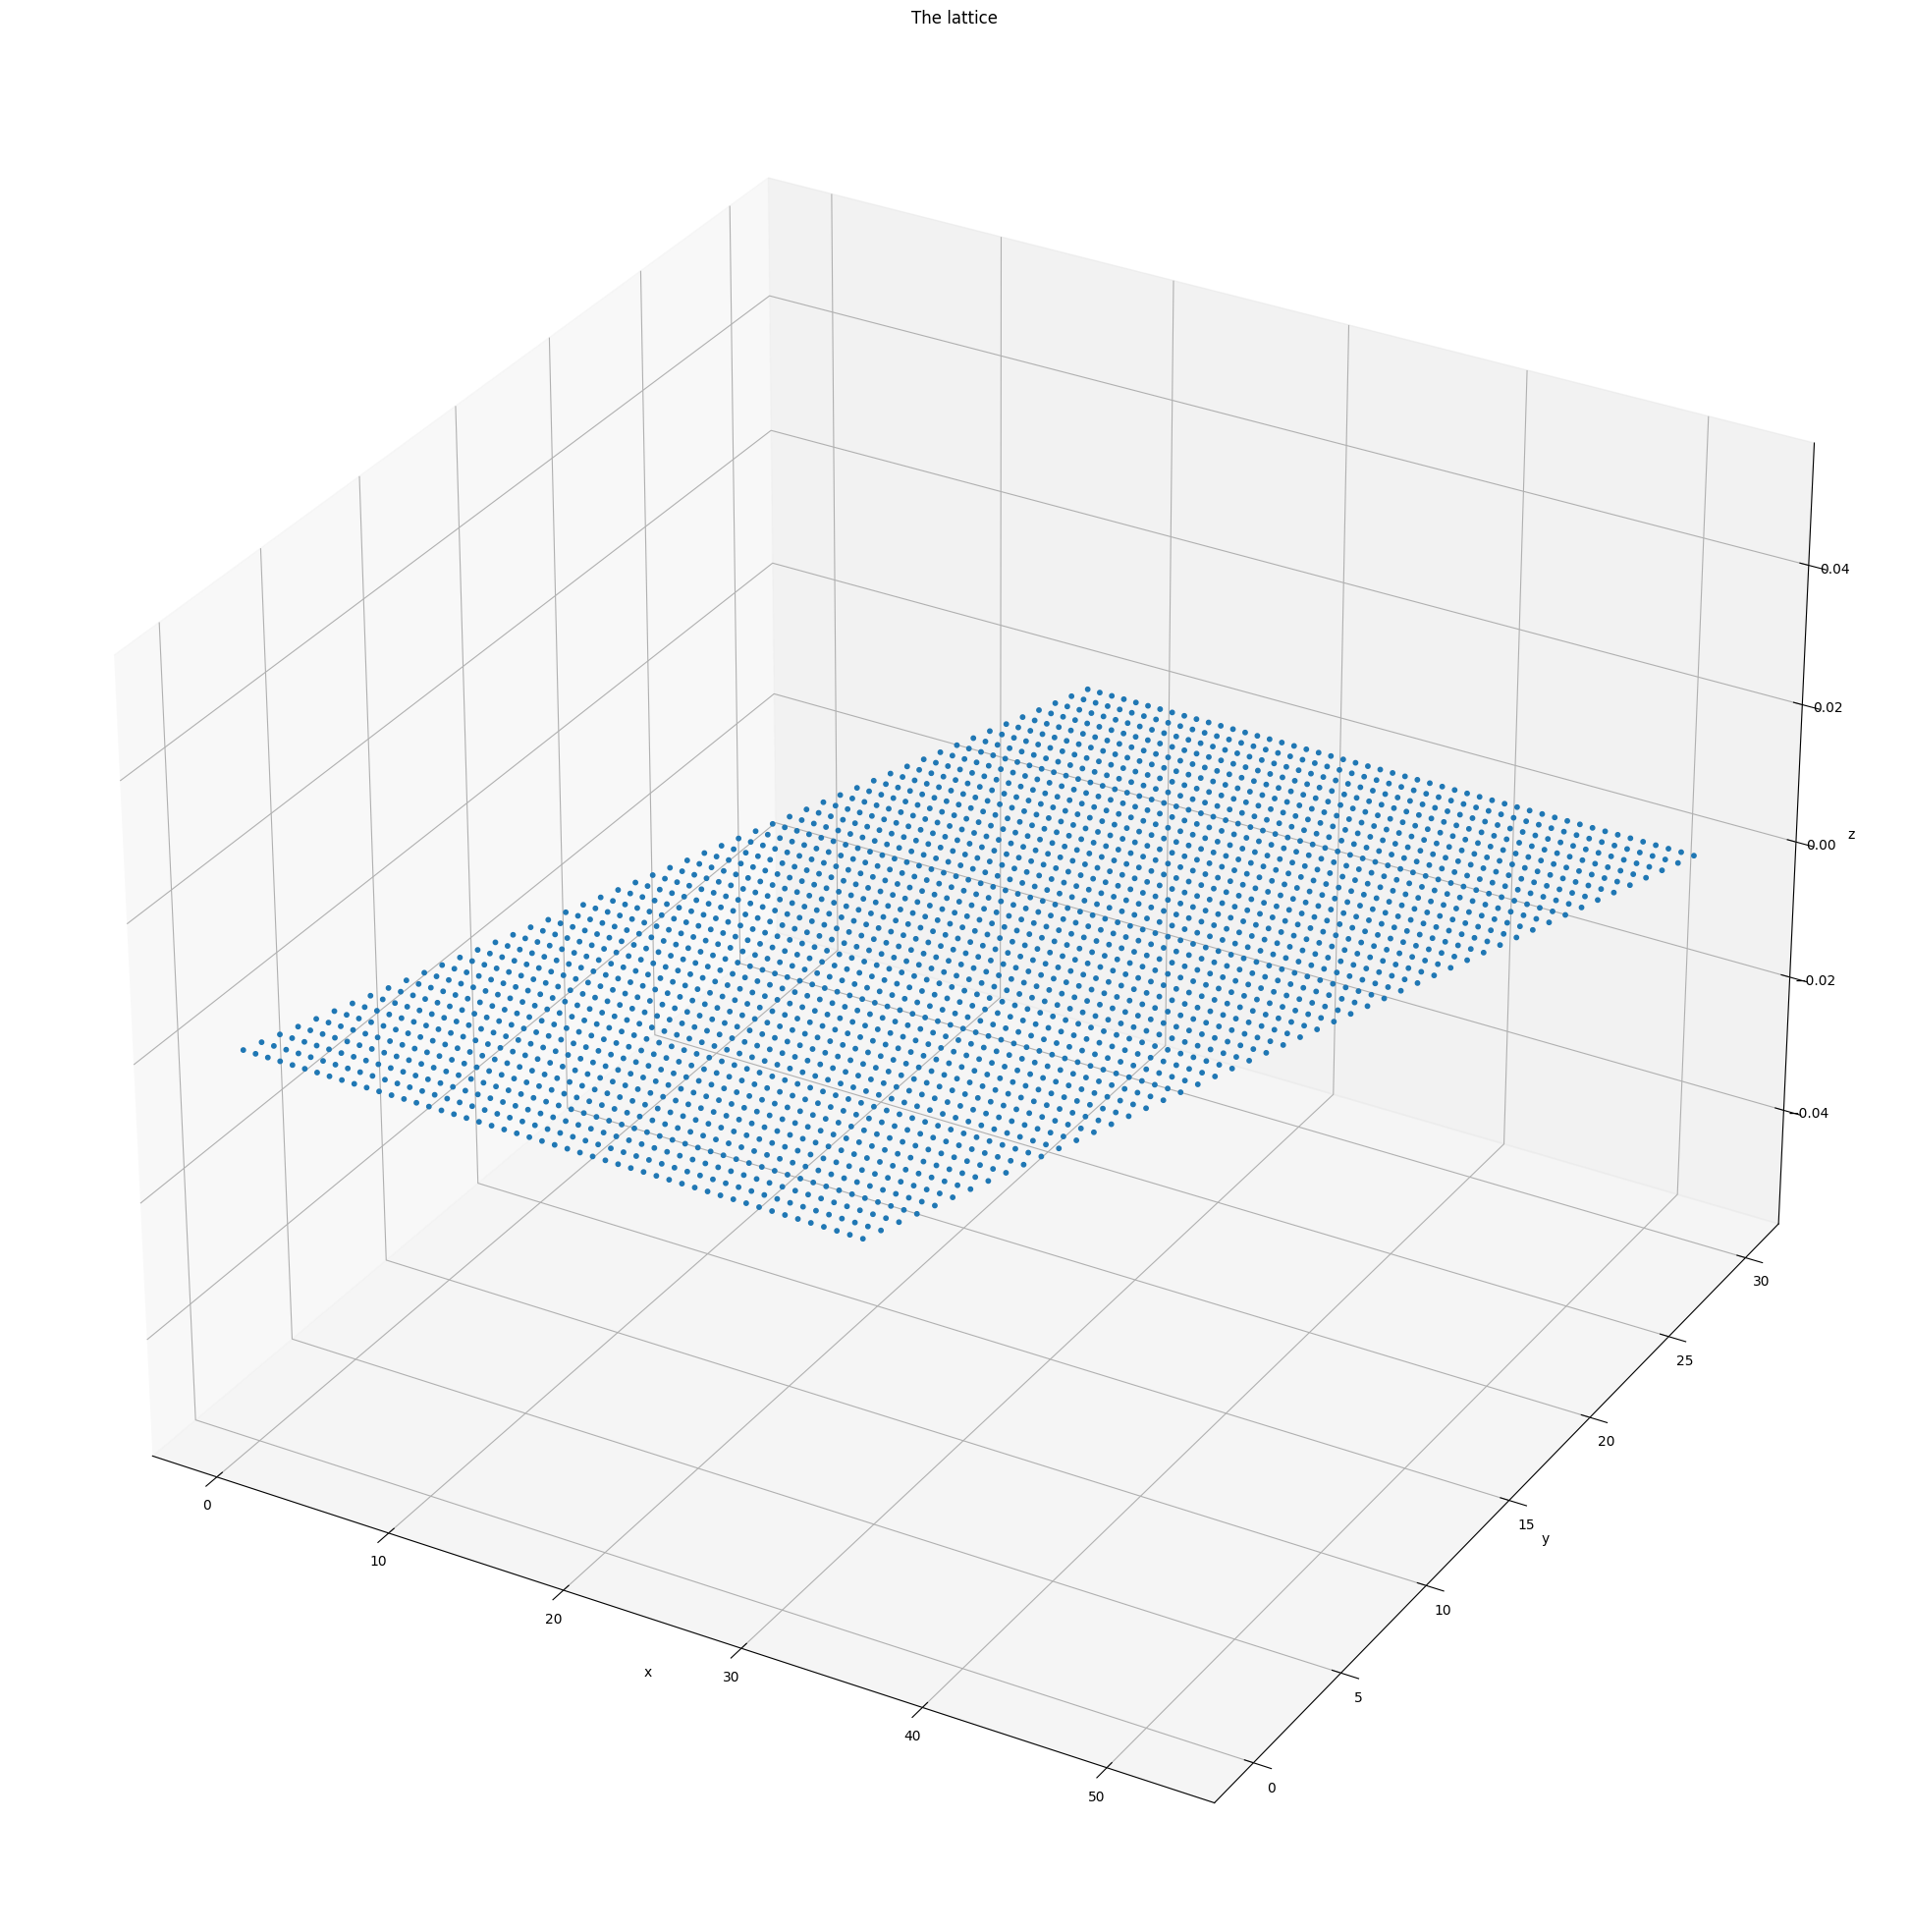

In [106]:
# plot the lattice points in 3D
def f(x):
    return 100*np.exp(x-10)/(1+np.exp(x-10))

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111, projection='3d')

# extract the x, y, and z coordinates of each lattice site
x = positions_lattice[:,:,0].flatten()
y = positions_lattice[:,:,1].flatten()
z = positions_lattice[:,:,2].flatten()

# plot the points as a scatter plot with larger point size and more spacing
ax.scatter(x, y, z, s=1000/f(side_spins), alpha=1.0)

# set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('The lattice')

plt.show()

In [107]:
## Extract the distance vectors and corresponding interactions for each site
## Apply the condition Dij = -Dji
n_sites = total_spins
interactions_lattice = np.zeros_like(distance_vectors)

for idx in range(n_sites):
    groups_int_now = np.zeros_like(distance_vectors[idx])
    for i in range(len(groups_int[idx][:,0])):
        groups_int_now[i] = groups_int[idx][:,0][i]
    for i in range(len(neighbors_lattice[idx])):
        distance_vector_now = distance_vectors[idx][i]
        i_contrary = np.where(np.all(np.isclose(distance_vectors[idx], np.negative(distance_vector_now), rtol=1e-2), axis=1))[0][0]
        if np.allclose(np.linalg.norm(interactions_lattice[idx][i]), 0) and np.allclose(np.linalg.norm(interactions_lattice[idx][i_contrary]), 0):
            idx_groups_int = np.where(np.all(np.isclose(np.array(groups_int_now), distance_vector_now, rtol=1e-2), axis=1))[0][0]
            interaction_now = groups_int[idx][idx_groups_int, 1]
            interactions_lattice[idx][i] = interaction_now
            interactions_lattice[idx][i_contrary] = np.negative(interaction_now) 

In [108]:
## Verify if the Dij = -Dji condition is really satisfied
count1 = 0; count2 = 0
for site_idx in range(n_sites):
    for neighbor_idx in range(len(magnitudes)):
        neighbor_site_idx = neighbors_lattice[site_idx, neighbor_idx]
        interaction_i_j = interactions_lattice[site_idx, neighbor_idx]
        interaction_j_i = interactions_lattice[site_idx, np.where(np.all(np.isclose(distance_vectors[site_idx,:], np.negative(distance_vectors[site_idx][neighbor_idx]), rtol=1e-2), axis=1))[0][0]]
        count1 += 1
        if np.allclose(interaction_i_j, -interaction_j_i, rtol=1e-4):
            count2 += 1
        else:
            print(f"ERROR: Interactions between site {site_idx} and {neighbor_site_idx} are NOT opposite.")
if count1 == count2:
    print("Everything ok!")

Everything ok!


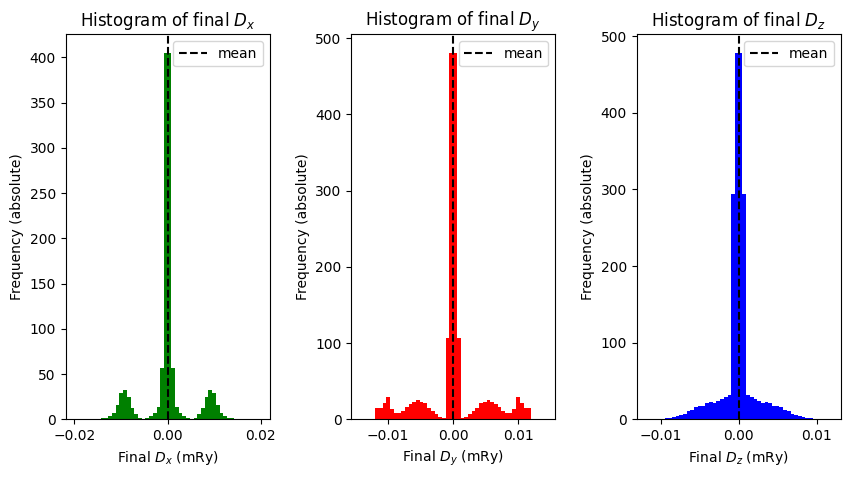

The mean final magnitude is 0.06 meV.


In [109]:
## Show how the DMI interactions look like after constrains

final_magnitudes = np.linalg.norm(interactions_lattice, axis=2).flatten()
final_x_components = interactions_lattice[:,:,0].flatten()
final_y_components = interactions_lattice[:,:,1].flatten()
final_z_components = interactions_lattice[:,:,2].flatten()

## Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

## Plot histogram of x_componentes parameters
ax1.hist(final_x_components, bins=side_spins, density=True, color='green')
ax1.set_xlabel(r'Final $D_{x}$ (mRy)')
ax1.set_ylabel('Frequency (absolute)')
ax1.set_title(r'Histogram of final $D_{x}$')
ax1.axvline(np.mean(final_x_components), color='black', ls='--', label='mean')
ax1.legend(loc='best')

## Plot histogram of y_componentes parameters
ax2.hist(final_y_components, bins=side_spins, density=True, color='red')
ax2.set_xlabel(r'Final $D_{y}$ (mRy)')
ax2.set_ylabel('Frequency (absolute)')
ax2.set_title(r'Histogram of final $D_{y}$')
ax2.axvline(np.mean(final_y_components), color='black', ls='--', label='mean')
ax2.legend(loc='best')

## Plot histogram of z_componentes parameters
ax3.hist(final_z_components, bins=side_spins, density=True, color='blue')
ax3.set_xlabel(r'Final $D_{z}$ (mRy)')
ax3.set_ylabel('Frequency (absolute)')
ax3.set_title(r'Histogram of final $D_{z}$')
ax3.axvline(np.mean(final_z_components), color='black', ls='--', label='mean')
ax3.legend(loc='best')

## Adjust spacing between subplots!
fig.subplots_adjust(wspace=0.4)

## Display the plots
plt.show()

## Display the average magnitude!
print("The mean final magnitude is " + str(np.round(np.mean(final_magnitudes)*13.605693009, 2)) + " meV.")

/var/folders/ls/f_gxhb7j2kdc0tkgrythk1jc0000gn/T/ipykernel_22073/2794076430.py:24: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


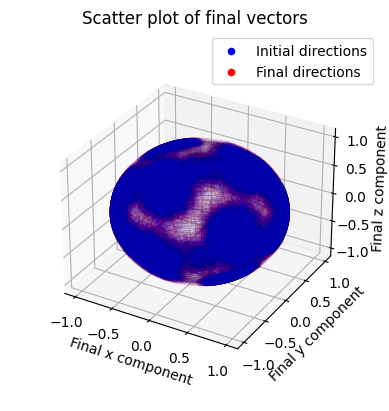

In [110]:
## Plot 3D scatter plot of vectors after constrains
if plot_3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if not around_initial_vectors:
        ax.scatter(x_components, y_components, z_components, color='blue', label='Initial directions', alpha=0.01)
        ax.scatter(final_x_components/final_magnitudes, final_y_components/final_magnitudes, final_z_components/final_magnitudes, color='red', label='Final directions', alpha=0.01)
        ax.quiver(0, 0, 0, x_component_initial_vector, y_component_initial_vector, z_component_initial_vector, color='black', linewidth=3, arrow_length_ratio=0.1)
    else:
        ax.scatter(x_components_cond.flatten(), y_components_cond.flatten(), z_components_cond.flatten(), color='blue', label='Initial directions', alpha=0.01)
        ax.scatter(final_x_components/final_magnitudes, final_y_components/final_magnitudes, final_z_components/final_magnitudes, color='red', label='Final directions', alpha=0.01)
    # Plot the sphere with lines of latitude and longitude
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='gray', linewidths=0.2)
    # End plot
    ax.set_xlabel('Final x component')
    ax.set_ylabel('Final y component')
    ax.set_zlabel('Final z component')
    ax.set_title('Scatter plot of final vectors')
    ax.dist = 12
    legend = ax.legend(scatterpoints=1)
    legend.legendHandles[0].set_alpha(1)
    legend.legendHandles[1].set_alpha(1)
    plt.show()

In [21]:
## Get the order of interactions equivalent of distance_vectors
interactions_jfile = np.zeros((n_sites, len(magnitudes)))
for j in range(n_sites):
    for i in range(len(distance_vectors[j])):
        idx = np.where(np.all(np.isclose(positions_jfile, distance_vectors[j][i], rtol=1e-2), axis=1))[0][0]
        interactions_jfile[j][idx] = jvalues[idx]

In [22]:
## Write posfile
posfile_new = open('posfile.new', 'w')
pos_reshape = positions_lattice.reshape((total_spins, 3))
for i in range(len(pos_reshape)):
    print("{:d} {:d} {:.7f} {:.7f} {:.7f}".format(i+1, i+1, pos_reshape[i][0], pos_reshape[i][1], pos_reshape[i][2]), file=posfile_new)
    
## Write jfile
jfile_new = open('jfile.new', 'w')
for i in range(len(interactions_jfile)):
    for j in range(len(interactions_jfile[0])):
        norm_distance = np.linalg.norm(distance_vectors[i][j])
        print("{:d} {:d} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f}".format(i+1, neighbors_lattice[i][j]+1, -distance_vectors[i][j][0], -distance_vectors[i][j][1], -distance_vectors[i][j][2], interactions_jfile[i][j], norm_distance), file=jfile_new)

## Write DMI
dm_new = open('dm.new', 'w')
for i in range(len(interactions_lattice)):
    for j in range(len(interactions_lattice[0])):
        norm_distance = np.linalg.norm(distance_vectors[i][j])
        print("{:d} {:d} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f}".format(i+1, neighbors_lattice[i][j]+1, distance_vectors[i][j][0], distance_vectors[i][j][1], distance_vectors[i][j][2], interactions_lattice[i][j][0], interactions_lattice[i][j][1], interactions_lattice[i][j][2], norm_distance), file=dm_new)
        
## Write momfile
momfile_new = open('momfile.new', 'w')
for i in range(len(pos_reshape)):
    print("{:d} {:d} {:.7f} {:.7f} {:.7f} {:.7f}".format(i+1, 1, moment_value, initial_vector_mag[0], initial_vector_mag[1], initial_vector_mag[2]), file=momfile_new)
    
## Write kfile
kfile_new = open('kfile.new', 'w')
for i in range(len(pos_reshape)):
    print("{:d} {:d} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f} {:.7f}".format(i+1, anisotropy_type, anisotropy_k1, anisotropy_k2, vector_anisotropy[0], vector_anisotropy[1], vector_anisotropy[2], anisotropy_ratio), file=kfile_new)

In [23]:
## For inpsd.dat
cell_sized = side_spins*cell[0:2]
print("cell {:.7f} {:.7f} {:.7f}".format(cell_sized[0][0], cell_sized[0][1], cell_sized[0][2]))
print("     {:.7f} {:.7f} {:.7f}".format(cell_sized[1][0], cell_sized[1][1], cell_sized[1][2]))
print("     {:.7f} {:.7f} {:.7f}".format(cell[2][0], cell[2][1], cell[2][2]))

cell 35.3500000 0.0000000 0.0000000
     17.6750000 30.6150000 0.0000000
     0.0000000 0.0000000 1.0000000
